In [1]:
import pandas as pd
import numpy as np

PATH = "./data/"
train = pd.read_csv(PATH+'train.csv')
test = pd.read_csv(PATH+'test.csv')
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
print(train.shape)
train.describe()

(891, 12)


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [4]:
print(test.shape)
test.describe()

(418, 11)


,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


In [5]:
from sklearn.preprocessing import Normalizer

# 数据预处理
def preprocess(data):
    # Data Cleaning
    data = data.drop(columns=['PassengerId'], axis=1)
    data['UknAge'] = data['Age'].map(lambda x: x>0).astype(int)
    data['Age'] = data['Age'].fillna(0)
    data['Fare'] = data['Fare'].fillna(data['Fare'].median())
    data['Embarked'] = data['Embarked'].fillna('S')
    #### One-hot Encoding
    data['Pclass'] -= 1
    data['Sex'] = data['Sex'].map({'male': 0, 'female': 1})
    data['Embarked'] = data['Embarked'].map({'C': 0, 'Q': 1, 'S': 2})
    dummy_features = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked']
    data = pd.get_dummies(data, columns=dummy_features, dtype=float)
    
    data = data.fillna(0)
    #### Normalization
    num_features = ['Age', 'Fare']
    data[num_features] = Normalizer().fit_transform(data[num_features])
    #### To List
    data.drop(columns=data.columns[data.dtypes=='object'], axis=1, inplace=True)
    return data

In [6]:
traindf = preprocess(train)
testdf = preprocess(test)

In [7]:
print(traindf.shape)
print(testdf.shape)

(891, 26)
(418, 26)


In [8]:
print(set(traindf.columns)-set(testdf.columns))
set(testdf.columns)-set(traindf.columns)

{'Survived'}


{'Parch_9'}

In [9]:
testdf.drop(columns={'Parch_9'}, axis=1, inplace=True)

In [10]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleNN(nn.Module):
    def __init__(self, n_features):
        super().__init__()
        self.layer1 = nn.Linear(n_features, 128)
        self.layer2 = nn.Linear(128, 256)
        self.layer3 = nn.Linear(256, 128)
        self.layer4 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.layer1(x)
        x = F.relu(x)
        x = self.layer2(x)
        x = F.relu(x)
        x = self.layer3(x)
        x = F.relu(x)
        x = self.layer4(x)
        x = torch.sigmoid(x)
        return x

In [15]:
from torch.utils.data import Dataset

class SimpleDataset(Dataset):
    def __init__(self, x, y):
        super().__init__()
        self.x = x
        self.y = y
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [26]:
X, y = traindf.drop(columns=['Survived'], axis=1).values, traindf[['Survived']].values

#train_x = train_x[train_x.keys()].values
#test_x = test_x[test_x.keys()].values
#train_y = train_y.values

import torch
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.model_selection import KFold

k_folds = 5
kfold = KFold(n_splits=k_folds, shuffle=True)

simple_dataset = SimpleDataset(X, y)

loss_list = []
acc_list = []

for fold, (train_ids, valid_ids) in enumerate(kfold.split(simple_dataset)):
    print(f'FOLD {fold}')
    print('--------------------------------')
    train_subsampler = SubsetRandomSampler(train_ids)
    valid_subsampler = SubsetRandomSampler(valid_ids)
    
    train_loader = DataLoader(simple_dataset, batch_size=99, sampler=train_subsampler)
    valid_loader = DataLoader(simple_dataset, batch_size=99, sampler=valid_subsampler)
    
    simple_nn = SimpleNN(n_features=X.shape[1])
    optimizer = optim.Adam(simple_nn.parameters(), lr=0.01)
    error = nn.BCELoss()
    
    for epoch in range(300):
        with torch.no_grad():
            valid_loss = 0
            num_right = 0
            for tensor_x, tensor_y in valid_loader:
                tensor_x = tensor_x.float()
                tensor_y = tensor_y.float().reshape(-1, 1)
                output = simple_nn(tensor_x)
                loss = error(output, tensor_y)
                valid_loss += loss.item() * len(tensor_x)
                result = [1 if out >= 0.5 else 0 for out in output]
                num_right += np.sum(np.array(result) == tensor_y.numpy().reshape(-1))
            
            valid_loss = valid_loss / len(valid_loader.sampler.indices)
            valid_accuracy = num_right / len(valid_loader.sampler.indices)
        
            if epoch % 50 == 0:
                print('Epoch:{} Valid Loss: {} Accuracy: {} '.format(epoch, valid_loss, valid_accuracy))

        train_loss = 0
        num_right = 0
        for tensor_x, tensor_y in train_loader:
            tensor_x = tensor_x.float()
            tensor_y = tensor_y.float().reshape(-1, 1)
            optimizer.zero_grad()
            output = simple_nn(tensor_x)
            loss = error(output, tensor_y)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * len(tensor_x)
            result = [1 if out >= 0.5 else 0 for out in output]
            num_right += np.sum(np.array(result) == tensor_y.numpy().reshape(-1))
        
        train_loss = train_loss / len(train_loader.sampler.indices)
        accuracy = num_right / len(train_loader.sampler.indices)
    
        if epoch % 50 == 0:
            print('Epoch:{} Loss: {} Accuracy: {} '.format(epoch, train_loss, accuracy))
            print('='*50)
               
    loss_list.append(valid_loss)
    acc_list.append(valid_accuracy)

print('Training Ended')
print('Average Loss: {} Average Accuracy: {}'.format(np.mean(loss_list), np.mean(acc_list)))

FOLD 0
--------------------------------
Epoch:0 Valid Loss: 0.7045423471727851 Accuracy: 0.3687150837988827 
Epoch:0 Loss: 0.5619045581375615 Accuracy: 0.6671348314606742 
Epoch:50 Valid Loss: 0.6045786595211349 Accuracy: 0.7877094972067039 
Epoch:50 Loss: 0.30517646063412174 Accuracy: 0.8665730337078652 
Epoch:100 Valid Loss: 0.6529930763404462 Accuracy: 0.776536312849162 
Epoch:100 Loss: 0.3125474414463793 Accuracy: 0.8735955056179775 
Epoch:150 Valid Loss: 0.7951444107726966 Accuracy: 0.776536312849162 
Epoch:150 Loss: 0.2782262073348412 Accuracy: 0.8778089887640449 
Epoch:200 Valid Loss: 1.3509701836708539 Accuracy: 0.7821229050279329 
Epoch:200 Loss: 0.273325411330783 Accuracy: 0.8792134831460674 
Epoch:250 Valid Loss: 2.102235838021646 Accuracy: 0.7877094972067039 
Epoch:250 Loss: 0.2643835249492961 Accuracy: 0.8735955056179775 
FOLD 1
--------------------------------
Epoch:0 Valid Loss: 0.7051413410835052 Accuracy: 0.3539325842696629 
Epoch:0 Loss: 0.6087214733992519 Accuracy: 0

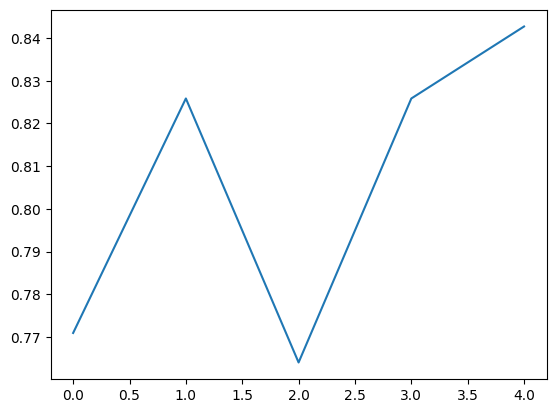

In [27]:
import matplotlib.pyplot as plt
plt.plot(acc_list)

In [17]:
tensor_test_x = torch.FloatTensor(testdf.values)

with torch.no_grad():
    test_output = simple_nn(tensor_test_x)
    result = np.array([1 if out >= 0.5 else 0 for out in test_output])
    submission = pd.DataFrame({'PassengerId': test['PassengerId'], 'Survived': result})
submission

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
